### Go to Drive & Project Folder


In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Projects/Covid-classification

Mounted at /content/drive
/content/drive/MyDrive/Projects/Covid-classification


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn.utils import compute_class_weight

###Data Generator:

In [3]:
from keras.preprocessing.image import ImageDataGenerator
Size=224
B_size=16
Train_path='MergedData/Train'

class_map = {'Covid': 1, 'Normal': 0}
train_datagen=ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                  rescale=1./255)
train_generator=train_datagen.flow_from_directory(Train_path,
                                                  class_mode='binary',
                                                  color_mode='rgb',
                                                  batch_size=B_size,
                                                  target_size=(Size,Size))


# Manually set the class indices
train_generator.class_indices = class_map

Found 1713 images belonging to 2 classes.


In [4]:
images,labels=next(train_generator)
print(len(train_generator))
print(images.shape)
print(labels.shape)

108
(16, 224, 224, 3)
(16,)


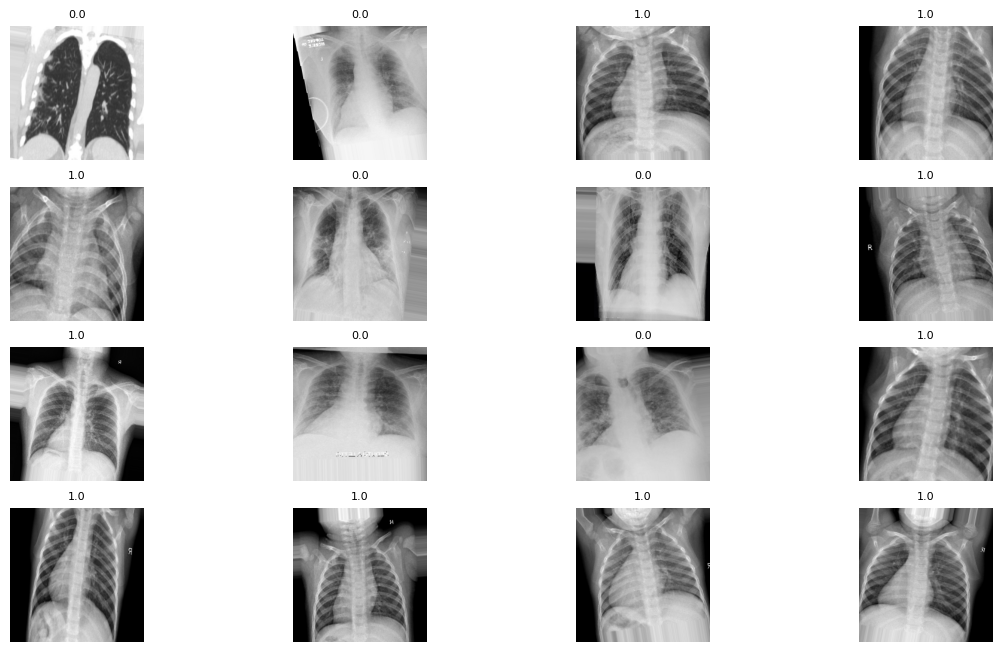

In [5]:
fig, axes = plt.subplots(4,4, figsize=(14, 8), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(labels[i], fontsize=8)
    ax.axis('off')

In [6]:
#compute class wieghts
class_weights = compute_class_weight('balanced', classes=list(class_map.values()), y=train_generator.classes)
class_weight_dict=dict(zip(np.unique(train_generator.classes),class_weights))
class_weight_dict

{0: 0.7101990049751243, 1: 1.6893491124260356}

In [7]:
Test_path='MergedData/Test'

class_map = {'Covid': 1, 'Normal': 0}

test_datagen=ImageDataGenerator(rescale=1./255)

test_generator=train_datagen.flow_from_directory(Test_path,
                                                  class_mode='binary',
                                                  color_mode='rgb',
                                                  batch_size=B_size,
                                                  target_size=(Size,Size))


# Manually set the class indices
test_generator.class_indices = class_map

Found 191 images belonging to 2 classes.


### Loading model:


make Transfer Learning From Pneumonia Xray

that will helps to get accuracy

In [10]:
from tensorflow.keras.saving import load_model
from tensorflow.keras.optimizers import Adam

In [13]:
model=load_model('/content/drive/MyDrive/Projects/Pneumonia-classification/Pneumonia_Model.h5')

for layer in model.layers[:-5]:
  layer.trainable=False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [14]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='binary_crossentropy',metrics=['Accuracy'])

In [15]:
history=model.fit(train_generator,
          epochs=40,
          steps_per_epoch=len(train_generator),
          class_weight=class_weight_dict)

Epoch 1/40
108/108 [==============================] - 63s 548ms/step - loss: 0.6538 - Accuracy: 0.6795
Epoch 2/40
108/108 [==============================] - 59s 551ms/step - loss: 0.3902 - Accuracy: 0.8856
Epoch 3/40
108/108 [==============================] - 60s 555ms/step - loss: 0.3701 - Accuracy: 0.8938
Epoch 4/40
108/108 [==============================] - 60s 556ms/step - loss: 0.3452 - Accuracy: 0.9083
Epoch 5/40
108/108 [==============================] - 59s 547ms/step - loss: 0.3435 - Accuracy: 0.9101
Epoch 6/40
108/108 [==============================] - 60s 553ms/step - loss: 0.3293 - Accuracy: 0.9171
Epoch 7/40
108/108 [==============================] - 60s 555ms/step - loss: 0.3279 - Accuracy: 0.9148
Epoch 8/40
108/108 [==============================] - 60s 552ms/step - loss: 0.3017 - Accuracy: 0.9305
Epoch 9/40
108/108 [==============================] - 59s 549ms/step - loss: 0.3245 - Accuracy: 0.9218
Epoch 10/40
108/108 [==============================] - 60s 556ms/step - l

### Model Evaluation:

In [16]:
model.evaluate(test_generator,steps=len(test_generator))

12/12 [==============================] - 43s 4s/step - loss: 0.3210 - Accuracy: 0.9215


[0.3209686875343323, 0.9214659929275513]

In [20]:
from sklearn.metrics import classification_report
images,y=next(test_generator)
pred=model.predict(images)
threshold = 0.5
pred = (pred > threshold).astype(int)

report = classification_report(y,pred)

print(report)


1/1 [==============================] - 0s 37ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         6
         1.0       0.71      1.00      0.83        10

    accuracy                           0.75        16
   macro avg       0.86      0.67      0.67        16
weighted avg       0.82      0.75      0.71        16



In [22]:
model.save('covid-model.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
